# アンサンブルKF PO法

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
# from numpy.random import Generator, MT19937

#sns.set_theme()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
#sns.set(font=['Hiragino sans'])

In [2]:
def RungeKutta4(initial, time, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    dt = time[1] - time[0]
    states = [initial]
    x = initial
    for t in time[:-1]:
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
        states.append(x)
    states = np.stack(states)
    return states

def RK4(x, dt, model, F):
    """
    Parameters
    ----------
    F : 
        Forcing constant, variable used in L96
    """
    for i in range(1):
        k1 = model(x, F)
        x1 = x + k1 * dt/2
        k2 = model(x1, F)
        x2 = x + k2 * dt/2
        k3 = model(x2, F)
        x3 = x + k3 * dt
        k4 = model(x3, F)
        x = x + (k1 + 2*k2 + 2*k3 + k4) * dt / 6
    return x

def L96(x, F):
    """
    Lorenz 96 model with constant forcing.
    Cited by "https://en.wikipedia.org/wiki/Lorenz_96_model"
    
    Parameters
    ----------
    x : 
        variables
    F :
       Forcing constant 
    N : int
        number of sites
    """
    N = 40
    # Setting up vector
    d = np.zeros(N, dtype=np.float_)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


def simulatior(time_step=0.01):
    N = 40
    F = 8.0
    ratio = 0.001
    year = 2
#     time_step = 0.01
    total_step = 0.2 * 365 * year
    time = np.arange(0.0, total_step + time_step, time_step, dtype=float)

    x = np.full(N, F, dtype=np.float_)
    x[19] += F * ratio
    dat = RungeKutta4(x, time, L96, F=F)

In [3]:
with open("RK4_GeneratedData.pkl", "rb") as f:
    origin = pickle.load(f)    
with open("NormalNoise.pkl", "rb") as f:
    noise = pickle.load(f)
    
# dat = simulatior(0.001)
# seed = 46
# rg = Generator(MT19937(seed))
# # ノイズとして加える正規分布
# noise = rg.standard_normal(dat.shape)

In [4]:
"""
一年分のstep回数は以下の計算式だから、
後半1年分をとる。
datのtims_stepは0.01刻み
"""
obs_dat = origin + noise
time_step = 0.01
total_step = int(0.2 * 365 / time_step)
origin = origin[total_step:, :]
obs_dat = obs_dat[total_step:, :]

# 0.05=6(h)ごとのデータを抽出
t = int(0.05 / time_step)
six_hour = np.arange(0, len(obs_dat), t, dtype=int)
origin = origin[six_hour, :]
obs_dat = obs_dat[six_hour, :]

In [5]:
print(obs_dat.shape)
obs_dat.dtype = np.float_

(1461, 40)


In [6]:
# 変数
N = 40
I = np.identity(N, dtype=np.float_)
H = np.identity(N, dtype=np.float_)
R = np.identity(N, dtype=np.float_)
alpha = 1.2
delta = 1e-8
dt = 0.05

In [7]:
def one_shotEnKF(x_a, y_o, alpha=alpha, delta=delta, dt=dt, I=I, H=H, R=R):
    """
    KFの一回単位のシミュレーション。
    
    Parameter
    ---------
    x_a : 
    P_a :
    y_o :
    alpha :
        共分散膨張率
    delta : 
        Mの接線形近似のパラメタ
    dt : 0.05
        RK4のtime step。
    I :
    H :
    R :
    
    Return
    ------
    x_a, P_a
    """
    x_f = np.zeros((N, en))
    dX_f = np.zeros((N, en))
    x_aa = np.zeros((N, en))

    for j in range(en):
        x_f[:, j] = RK4(x_a[:, j], dt, model=L96, F=8)
    #print(x_f[0, 0], x_a[0, 0])
    x_bar = np.mean(x_f, axis=1)
    for j in range(en):
        dX_f[:, j] += x_f[:, j] - x_bar
    dY_f = H @ dX_f

    P_f = dX_f @ dX_f.T / (en - 1)
    K = P_f * H.T * np.linalg.inv(H * P_f * H.T + R)
    y_o = obs_dat[i, :]
    #x_a = x_f + K @ (y_o - H @ x_f)
    #x_a = x_a
    P_a = (I - K @ H) @ P_f @ (I - K @ H).T
    #y_o = obs_dat[i, :]
    for j in range(en):
        e_o = np.random.normal(0, 1, 40)
        x_aa[:, j] = x_f[:, j] + K @ (y_o + e_o - H @ x_f[:, j])
    return x_aa, P_a


    #for i in range(en):
    #    x_f[:, i] = RK4(x_a[:, i], dt, model=L96, F=8)
    #print(x_f[0, 0], x_a[0, 0])
    #x_bar = np.mean(x_f, axis=1)
    #dX_f = np.zeros_like(x_bar)
    #for i in range(en):
    #    dX_f[:, i] += x_f[:, i] - x_bar
    #dY_f = H @ dX_f
    #K = dX_f @ dY_f.T @ np.linalg.inv(dY_f @ dY_f.T + ((en - 1) * R))
    #y_o = obs_dat[i, :]
    #for i in range(en):
    #    e_o = np.random.normal(0, 0.1, 40)
    #    x_aa[:, i] = x_f[:, i] + K @ (y_o + e_o - H @ x_f[:, i])
    #print(np.max(x_a))
    #return x_aa, K

In [11]:
# 変数
N = 40
mm = 40
en = 1000 #アンサンブル数
I = np.identity(N, dtype=np.float_)
H = np.identity(N, dtype=np.float_)
R = np.identity(mm, dtype=np.float_)
dt = 0.05

x_f = np.random.normal(2, 3, (N, en))
x_a = x_f



# KF simulation
x_analyze = [x_a]
kk = []
for i in range(1, len(obs_dat)):
    y_o = obs_dat[i, :]
    x_a, K = one_shotEnKF(x_a, y_o, mm)
    x_analyze.append(x_a)
    kk.append(K)
x_analyze = np.stack(x_analyze)
kk = np.stack(kk)


Text(0.5, 1.0, 'ある地点での解析結果(500stepまで)')

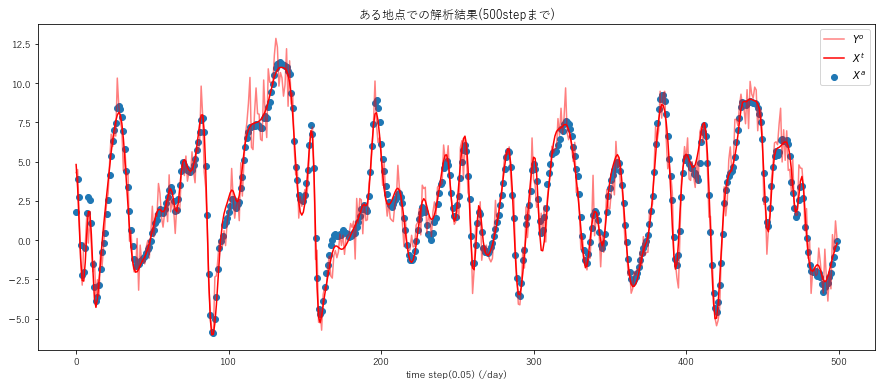

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
length = 500
t = 39
s = 99
ax.scatter(range(len(x_analyze[:length, t, s])), x_analyze[:length, t, s], label="$X^a$")
# ax.plot(x_analyze[:500, 1])
ax.plot(obs_dat[:length, t], alpha=0.5, color='r', label="$Y^o$")
ax.plot(origin[:length, t], label="$X^t$", color="red")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title(f"ある地点での解析結果({length}stepまで)")

In [10]:
x_a

array([[ 1.30802514,  1.34060124,  0.89265634, ...,  0.99050848,
         1.08551902,  1.80165333],
       [ 3.01874855,  3.17264953,  3.18113107, ...,  3.23258568,
         3.13812456,  3.33428539],
       [ 5.46445813,  4.90327584,  4.88274806, ...,  4.87092917,
         4.81026759,  4.65309628],
       ...,
       [ 3.9193294 ,  5.12175169,  4.09535293, ...,  4.1962592 ,
         4.62893689,  3.05897036],
       [-2.57803092, -2.58028711, -3.0433365 , ..., -2.90991429,
        -2.88065134, -2.69268638],
       [ 3.08067809,  2.44983518,  2.32605824, ...,  2.62154277,
         2.33125537,  3.02174491]])

In [18]:
err = np.power(x_analyze[:,:,10] - origin, 2).sum(axis=1) / 40
print(np.average(np.sqrt(err[100:500])))

0.4700519561392538


Text(0.5, 1.0, '各time stepでの平均二乗誤差')

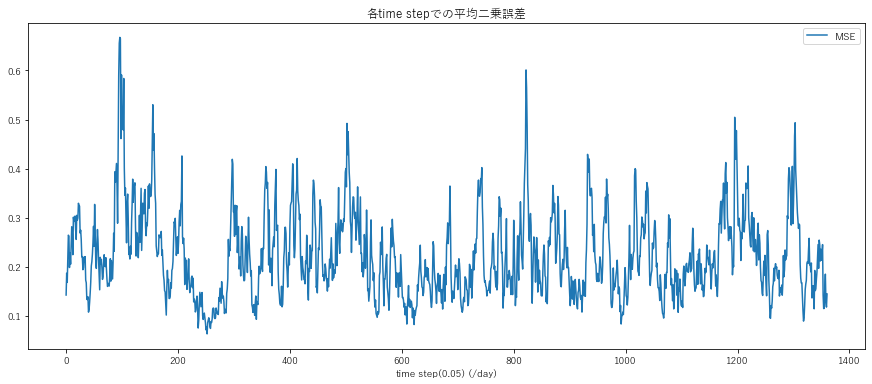

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(err[100:], label="MSE")
ax.legend()
ax.set_xlabel("time step(0.05) (/day)")
ax.set_title("各time stepでの平均二乗誤差")